In [2]:
import zipfile

with zipfile.ZipFile('drive/MyDrive/Colab Notebooks/fruit.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [3]:
import torch
import torchvision
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

El objetivo de este cuadernillo es el de utilizar un modelo preentrenado en este caso CONVNEXT, y aplicarlo usando Transfer Learning y Fine Turnning al dataset de clasificacion de frutas https://www.kaggle.com/datasets/sshikamaru/fruit-recognition.

El dataset contine 33 clases con 16854 ejemplos, cada imagen es de 100x100 píxeles.

In [4]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
dataset = torchvision.datasets.ImageFolder('train', transform=data_transform)

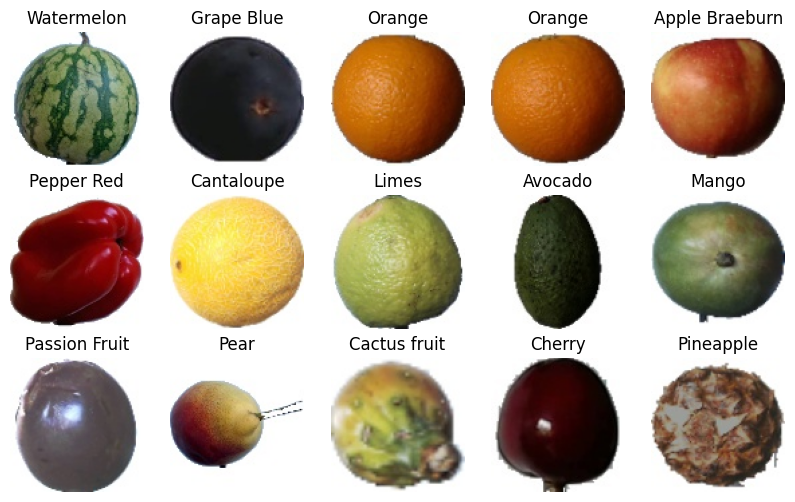

In [5]:
classes = sorted(os.listdir('train'), key=lambda x: x.lower())
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset)-1)
    img, lab = dataset[ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [6]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
print('train size:',train_size)
print('test size:',test_size)
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
# Se crea dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False)
dataloader = {
    'train': train_loader,
    'test': test_loader
}

train size: 11797
test size: 5057


In [7]:
imgs, labels = next(iter(train_loader))
print('Forma Xi:',imgs.shape)

Forma Xi: torch.Size([20, 3, 100, 100])


In [8]:
convnext = torchvision.models.convnext_small()
class Model(torch.nn.Module):
    def __init__(self, n_outputs=5, pretrained=False, freeze=False):
        super().__init__()
        # descargamos convnext
        convnext = torchvision.models.convnext_small(pretrained=pretrained)
        # nos quedamos con todas las capas menos la última
        self.convnext = torch.nn.Sequential(*list(convnext.children())[:-1])
        if freeze:
            for param in self.convnext.parameters():
                param.requires_grad = False
        # añadimos una nueva capa lineal para llevar a cabo la clasificación
        self.fc = torch.nn.Linear(768, 33)

    def forward(self, x):
        x = self.convnext(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def unfreeze(self):
        for param in self.convnext.parameters():
            param.requires_grad = True

In [9]:
def fit(model, dataloader, epochs=3, lr=0.1):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.cuda(), y.cuda()
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.cuda(), y.cuda()
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

## Transfer Learning

In [11]:
model = Model(pretrained=True, freeze=True).cuda()
fit(model, dataloader)

val_loss 0.09553 val_acc 0.98557: 100%|██████████| 253/253 [00:10<00:00, 25.17it/s]


/nEpoch 1/3 loss 0.60321 val_loss 0.09553 acc 0.91931 val_acc 0.98557


val_loss 0.07022 val_acc 0.99032: 100%|██████████| 253/253 [00:09<00:00, 25.71it/s]


/nEpoch 2/3 loss 0.20235 val_loss 0.07022 acc 0.97736 val_acc 0.99032


val_loss 0.04766 val_acc 0.99387: 100%|██████████| 253/253 [00:11<00:00, 22.68it/s]

/nEpoch 3/3 loss 0.24430 val_loss 0.04766 acc 0.97871 val_acc 0.99387


Utilizando Transfer Learning los resultado obtenidos son muy buenos comparados con el entrenamiento del modelo CONVNEXT desde cero con el dataset de clasificacion de frutas

## Fine Tuning

In [13]:
model = Model(pretrained=True, freeze=True).cuda()
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val_loss 0.36561 val_acc 0.97072: 100%|██████████| 253/253 [00:09<00:00, 25.79it/s]


/nEpoch 1/3 loss 0.59738 val_loss 0.36561 acc 0.92439 val_acc 0.97072


val_loss 0.12153 val_acc 0.99209: 100%|██████████| 253/253 [00:10<00:00, 25.15it/s]


/nEpoch 2/3 loss 0.31649 val_loss 0.12153 acc 0.96737 val_acc 0.99209


val_loss 0.03038 val_acc 0.99407: 100%|██████████| 253/253 [00:09<00:00, 25.34it/s]


/nEpoch 3/3 loss 0.23064 val_loss 0.03038 acc 0.97941 val_acc 0.99407


val_loss 0.21548 val_acc 0.97470: 100%|██████████| 253/253 [00:10<00:00, 24.80it/s]


/nEpoch 1/3 loss 0.19896 val_loss 0.21548 acc 0.98602 val_acc 0.97470


val_loss 0.00084 val_acc 0.99980: 100%|██████████| 253/253 [00:11<00:00, 22.52it/s]


/nEpoch 2/3 loss 0.02630 val_loss 0.00084 acc 0.99602 val_acc 0.99980


val_loss 0.00979 val_acc 0.99881: 100%|██████████| 253/253 [00:10<00:00, 24.58it/s]


/nEpoch 3/3 loss 0.03914 val_loss 0.00979 acc 0.99576 val_acc 0.99881


En este caso utilizamos fine tuning primero entrenando el modelo sin modificar los parametros de su preentrenamiento, despues se vuelve a entrenar con un lr mas pequeño y modificando los parametros del modelo preentrenado.
Los resultados obtenidos son mejores que solo utilizando transfer learning